# Ziad Al-Ziadi (150010258) - INM460 Computer Vision (2020/21)
### Module leader: Giacomo Tarroni

## Facial Emotion Recognition with MLP and SIFT (Scale-Invariant Feature Transform)

In the preceding section, we will implement several variations of a Facial Emotion Recognition (FER) solution. It will include a Multi-Layered Perceptron (MLP). The MLP will be used with SIFT and will make use of the Real-world Affective Faces (RAF) dataset consisting of facial images that depcit emotions that are labeled as:

1: Surprise
2: Fear
3: Disgust
4: Happiness
5: Sadness
6: Anger
7: Neutral

Ultimately, the objective is to have the MLP accurately predict the emotions in unseen images.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install opencv-python==4.4.0.46

In [ ]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
from skimage import exposure
from skimage.feature import hog
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.neural_network import MLPClassifier
import sklearn.metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import cv2

%matplotlib inline

In [ ]:
zip_path = "/content/drive/MyDrive/CV_Submission/CW_Dataset.zip"
!cp "{zip_path}" .
!yes|unzip -q CW_Dataset.zip

In [ ]:
# Creating the test and trian path

train_image_path = "/content/train"
test_image_path = "/content/test"

train_txt = "/content/labels/list_label_train.txt"
test_txt = "/content/labels/list_label_test.txt"

# Creating a dataframe from our label txt files

colnames = ["Image_id", "Label"]
train_lab = pd.read_csv(train_txt, names = colnames, header = None, delim_whitespace = True)
test_lab = pd.read_csv(test_txt, names = colnames, header = None, delim_whitespace = True)

In [ ]:
# Here, I'm cleaning the label string to isolate the label value

train_lab["Image_id"] = train_lab["Image_id"].apply(lambda i: i[:-4])
test_lab["Image_id"] = test_lab["Image_id"].apply(lambda i: i[:-4])

# I append the string "_aligned.jpg" so that it matches our image names

train_lab["Image_id"] = train_lab["Image_id"] + "_aligned.jpg"
test_lab["Image_id"] = test_lab["Image_id"] + "_aligned.jpg"

# Here, I carry out a little bit of renidexing: note I have to +1 after to maintain correct label value

train_lab["Label"] = train_lab["Label"].apply(lambda i: i - 1)
train_lab["Label"] = train_lab["Label"].apply(lambda i: i + 1)

test_lab["Label"] = test_lab["Label"].apply(lambda i: i - 1)
test_lab["Label"] = test_lab["Label"].apply(lambda i: i + 1)

In [ ]:
# This function takes a dataframe and applies the SIFT descriptor

def sift_des(data_frame):
  sift_img = []
  labels = []

  for i, row in data_frame.iterrows():
    img_path = "/content/train/"
    img_name = row[0]
    lbl = row[1]

    img_path += str(img_name)
    img = cv2.imread(img_path)
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    if des is not None:
      sift_img.append(des)
      labels.append(lbl)
  sift_array = np.vstack(sift_img)

  return sift_array, labels

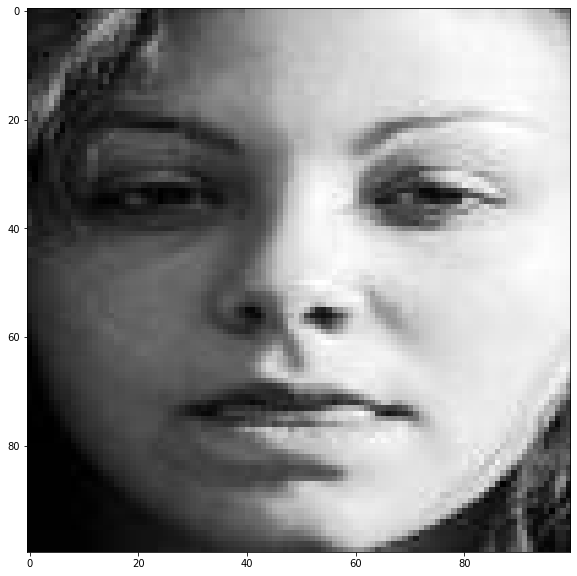

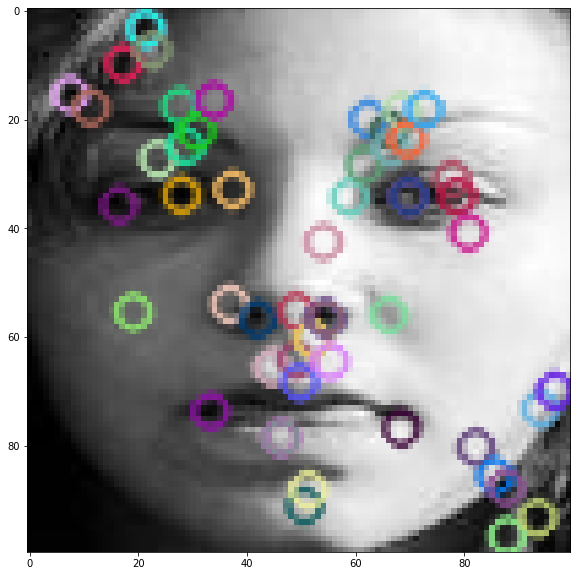

In [ ]:

for i, row in train_lab.iterrows():
  img_path = "/content/train/"
  img_name = row[0]
  
  img_path += str(img_name)
  img = cv2.imread(img_path)
  sift = cv2.SIFT_create()
  kp, des = sift.detectAndCompute(img, None)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

plt.figure(figsize=(10,10))
img_with_SIFT = cv2.drawKeypoints(img, kp, img)
plt.imshow(img_with_SIFT) 
plt.show()

In [ ]:
# Applying sift to our training set dataframe

sift_train, sift_train_lab = sift_des(train_lab)

# As per Lab 07, here we intialise the clustering of the descriptors to implement a BoVW approach

cluster = len(np.unique(sift_train_lab)) * 10
batch_size = sift_train.shape[0] // 4
k_means = MiniBatchKMeans(n_clusters = cluster, batch_size=batch_size).fit(sift_train)

In [ ]:
# Here, we slightly reformat the sift image array in similar fashion to our inital SIFT function

sift_img = []

for i, row in train_lab.iterrows():
  img_path = "/content/train/"
  img_name = row[0]
  img_path += str(img_name)
  img = cv2.imread(img_path)
  sift = cv2.SIFT_create()
  kp, des = sift.detectAndCompute(img, None)
  if des is not None:
    sift_img.append(des)

img_list = []

# Here, we obtain the histograms for each image
for x in sift_img:
    hist = np.zeros(cluster)

    idx = k_means.predict(x)
    for y in idx:
        hist[y] = hist[y] + (1 / len(x))
    img_list.append(hist)
sift_hist = np.vstack(img_list)

In [ ]:
# Now we can split our training data into X_train and y_train

X_train, _, y_train, _ = train_test_split(sift_hist, sift_train_lab, test_size = 0.1, shuffle=True)

In [ ]:
#Initialising our first MLP 

clf = MLPClassifier(
    hidden_layer_sizes = (50,100,50),
    activation = "relu",
    solver = "adam",
    alpha = 1e-5,
    batch_size = 64,
    learning_rate = "constant",
    shuffle = True,
    momentum = 0.7,
    early_stopping = True
)

In [ ]:
clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size=64, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(50, 100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.7, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
# Once our MLP has been trained on our training set, we can evaluate on our test

#Reading in test data

test_img = []
test_labels = []

for i, row in test_lab.iterrows():
  img_path = "/content/test/"
  img_name = row[0]
  lbl = row[1]
  img_path += str(img_name)
  img = cv2.imread(img_path)
  test_img.append(img)
  test_labels.append(lbl)

_, X_test, _, y_test = train_test_split(test_img, test_labels, test_size = .99, shuffle=True)

In [ ]:
hist_list = []

for x in range(len(X_test)):
    test_img = img_as_ubyte(color.rgb2gray(X_test[x]))
    kp, descrip = sift.detectAndCompute(test_img, None)

    #  Reapplying the same histogram logic from above
    if descrip is not None:
        img_hist = np.zeros(cluster)
        idx = k_means.predict(descrip)
        for y in idx:
            img_hist[y] = img_hist[y] + (1 / len(descrip))
        hist_list.append(img_hist)
    else:
        hist_list.append(None)

# Removing images with no descriptors
idx_not_empty = [i for i, x in enumerate(hist_list) if x is not None]
hist_list = [hist_list[i] for i in idx_not_empty]
y_test = [y_test[i] for i in idx_not_empty]
hist_array = np.vstack(hist_list)

In [ ]:
#Prediciting on test data

clf_pred = clf.predict(hist_array).tolist()
print(f"""Classification report for classifier {clf}:
      {metrics.classification_report(y_test, clf_pred)}\n""")

Classification report for classifier MLPClassifier(activation='relu', alpha=1e-05, batch_size=64, beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(50, 100, 50), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.7, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False):
                    precision    recall  f1-score   support

           1       0.33      0.22      0.26       327
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00       159
           4       0.46      0.81      0.59      1174
           5       0.33      0.06      0.11       473
           6       0.00      0.00      0.00       160
           7       0.38      0.37      0.37       

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mlp_params = {
    'hidden_layer_sizes': [(50,), (70,), (100,)],
    'activation': ["tanh",'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [ ]:
# The scores our MLP will use

mlp = MLPClassifier(max_iter = 500)

scores = ['recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        mlp, mlp_params, scoring='%s_macro' % score,  cv =2, n_jobs = -1
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on training set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on training set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Classification report for Train set:")
    print()
    y_true_train, y_pred_train = y_train, clf.predict(X_train)
    print(classification_report(y_true_train, y_pred_train))
    print()

    print("Classification report for Test set:")
    print()
    y_test_, y_pred_test = y_test, clf.predict(hist_array)
    print(classification_report(y_test_, y_pred_test))
    print()

# Tuning hyper-parameters for recall

Best parameters set found on training set:

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (70,), 'learning_rate': 'adaptive', 'solver': 'adam'}

Grid scores on training set:

0.193 (+/-0.007) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}
0.192 (+/-0.007) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.190 (+/-0.002) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (70,), 'learning_rate': 'constant', 'solver': 'adam'}
0.189 (+/-0.009) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (70,), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.190 (+/-0.006) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}
0.192 (+/-0.001) for {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (1

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


We can see that even with hyperparameters used with a grid search. the MLP stil performs poorly with SIFT.

In [ ]:
# We will now save our model as Pickle file in order to evaluate it with our other MLPs in another notebook

import pickle

with open("sift_mlp.pkl", "wb") as sift_mlp:
    pickle.dump(clf, sift_mlp)